In [2]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import os
import emoji
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#path = '/Users/cherylcai/Desktop/CSE 8803/Proj/Data/2020-08-output/'
#path = '/Users/cherylcai/Desktop/CSE 8803/Proj/Data/2020-09-output/'
#path = '/Users/cherylcai/Desktop/CSE 8803/Proj/Data/2020-10-output/'
#path = '/Users/cherylcai/Desktop/CSE 8803/Proj/Data/2020-11-output/'
path = '/Users/cherylcai/Desktop/CSE 8803/Proj/Data/2020-12-output/'

# read in all data
df_list = []
for file in os.listdir(path):
    # only read in csv files
    if not file.endswith('csv'):
        continue
    #print(file)
    # obtain the date for this file
    date = '-'.join(file.split(".")[0].split('-')[4:6])
    # load data and store in df
    df = pd.read_csv(path+file, names=['id','tweet','geo'])
    df['date'] = date
    df_list.append(df)

In [3]:
len(df_list)

744

In [4]:
df_all = pd.concat(df_list, axis=0, ignore_index=True)
df_all = df_all.sort_values('date')

In [5]:
df_all.shape

(1116000, 4)

In [6]:
stops = set(stopwords.words('english'))
# can add to stop words

wordnet_lemmatizer = WordNetLemmatizer()

In [7]:
def clean_tweet(tweet):
    # replace emoji with its text description 
    tweet = emoji.demojize(tweet, delimiters=("", "")) 
    # remove RT, @userid, links
    tweet = re.sub(r'(@[A-Za-z0–9_]+)|[^\w\s]|#|http\S+|RT', "", tweet)
    # remove the cuttoff word at the end
    tweet = re.sub(r'\s[a-z]+…','',tweet)
    # change to lowercase and remove \n
    tweet = tweet.lower().replace("\n"," ")
    #word tokenization
    tokens = word_tokenize(tweet)
    # remove stopwords and keep only letters
    tokens = [t for t in tokens if t.isalpha() and t not in stops and len(t)>1]
    # lemmatize tokens
    tokens = [wordnet_lemmatizer.lemmatize(t,pos="v") for t in tokens]
    # merge back to sentence
    clean_tweet = ' '.join(tokens)
    return clean_tweet

In [8]:
def lemmatize(tweet):
    tokens = tweet.split(' ')
    # lemmatize tokens
    tokens = [wordnet_lemmatizer.lemmatize(t,pos="v") for t in tokens]
    return tokens

In [9]:
df_all['clean_tweet'] = df_all['tweet'].apply(clean_tweet)
df_all['tokens'] = df_all['clean_tweet'].apply(lemmatize)

In [10]:
def polarity(tweet):
    return TextBlob(tweet).sentiment[0]
def sentiment_label(polarity):
    if polarity >0:
        return 'pos'
    elif polarity <0:
        return 'neg'
    else:
        return 'neu'

In [12]:
df_all['polarity'] = df_all['clean_tweet'].apply(polarity)
df_all['sentiment_label'] = df_all['polarity'].apply(sentiment_label)

In [13]:
df_all.to_csv('clean_tweets_12.csv',index=False)

In [14]:
df_all['date'].value_counts()

12-16    36000
12-21    36000
12-26    36000
12-17    36000
12-13    36000
12-27    36000
12-31    36000
12-02    36000
12-12    36000
12-18    36000
12-14    36000
12-11    36000
12-25    36000
12-28    36000
12-29    36000
12-24    36000
12-05    36000
12-09    36000
12-04    36000
12-03    36000
12-07    36000
12-01    36000
12-08    36000
12-23    36000
12-15    36000
12-22    36000
12-30    36000
12-19    36000
12-06    36000
12-20    36000
12-10    36000
Name: date, dtype: int64

In [15]:
df_cal = df_all[df_all['geo'].str.contains('CA|California|california|Cali|cali')]

In [16]:
df_cal['date'].value_counts()

12-06    5226
12-18    5156
12-05    5143
12-07    5055
12-25    5012
12-31    5010
12-24    5003
12-13    4985
12-09    4964
12-20    4962
12-08    4960
12-15    4958
12-10    4953
12-03    4946
12-04    4939
12-28    4928
12-26    4920
12-19    4919
12-27    4909
12-12    4886
12-11    4864
12-14    4860
12-30    4855
12-17    4806
12-29    4770
12-16    4747
12-23    4715
12-22    4672
12-21    4647
12-02    4612
12-01    4577
Name: date, dtype: int64

In [17]:
df1 = pd.crosstab(df_cal['date'],df_cal['sentiment_label'])
df1['total'] = df1['neg']+df1['pos']+df1['neu']
df1['pos_rate'] = df1['pos']/df1['total']
df1['neg_rate'] = df1['neg']/df1['total']
df1['date'] = df1.index
df1 = df1.reset_index(drop=True)
df1 = df1[['date','pos_rate','neg_rate']]

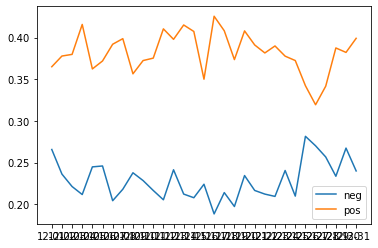

In [18]:
plt.plot(df1['date'],df1['neg_rate'],label='neg')
plt.plot(df1['date'],df1['pos_rate'],label='pos')
plt.legend()
plt.show()

In [19]:
# tokens = Counter(clean_text)
# tokens.most_common(10)

In [20]:
def fear_label(tokens):
    fear_words = set(['afraid','fear','worry','nervous','dread','scare','terrify','lockdown','lock'])
    if bool(fear_words & set(tokens)) == True:
        return 1
    else:
        return 0

def stay_home(tokens):
    stay_words = set(['stayhomechallenge','stayathome','stayhome'] )
    if 'stay' in tokens and 'home' in tokens:
        return 1
    elif bool(stay_words & set(tokens)) == True:
        return 1
    else:
        return 0

def mask_label(tokens):
    if 'wear' in tokens and 'mask' in tokens:
        return 1
    elif 'wearamask' in tokens:
        return 1
    else:
        return 0

In [21]:
df_cal['fear'] = df_cal['tokens'].apply(fear_label)
df_cal['stay'] = df_cal['tokens'].apply(stay_home)
df_cal['mask'] = df_cal['tokens'].apply(mask_label)

In [22]:
df2=pd.DataFrame()
df2['fear_count']=df_cal[df_cal['fear']==1].groupby('date')['id'].count().reset_index(drop=True)
df2['stay_count']=df_cal[df_cal['stay']==1].groupby('date')['id'].count().reset_index(drop=True)
df2['mask_count']=df_cal[df_cal['mask']==1].groupby('date')['id'].count().reset_index(drop=True)
df2['total_count'] = df_cal.groupby('date')['id'].count().reset_index(drop=True)
df2['fear_rate'] = df2['fear_count']/df2['total_count']
df2['stay_rate'] = df2['stay_count']/df2['total_count']
df2['mask_rate'] = df2['mask_count']/df2['total_count']

In [23]:
df2 = df2[['fear_rate','stay_rate','mask_rate']]
df3 = pd.concat([df1,df2],axis=1)

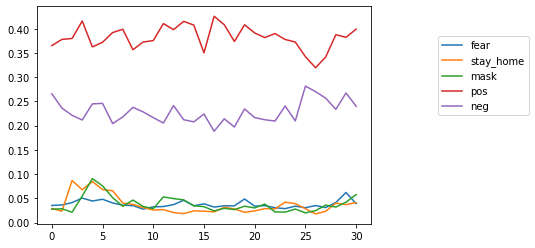

In [24]:
plt.plot(df3['fear_rate'],label='fear')
plt.plot(df3['stay_rate'],label='stay_home')
plt.plot(df3['mask_rate'],label = 'mask')
plt.plot(df3['pos_rate'],label = 'pos')
plt.plot(df3['neg_rate'],label = 'neg')
plt.legend(loc=[1.2,0.5])
plt.show()

In [25]:
df3.to_csv('tweet_features-12.csv',index=False)

In [ ]:
df_covid = pd.read_csv('/Users/cherylcai/Desktop/CSE 8803/Proj/Data/covid_cases_08-11.csv')

In [ ]:
df_covid

In [ ]:
df3['cal_cases'] = df_covid['cal_cases']
df3['cal_death'] = df_covid['cal_death']
df3['us_death'] = df_covid['us_death']
df3['us_cases'] = df_covid['us_cases']

In [ ]:
corr = df3.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='Blues')

In [ ]:
corr

In [3]:
df_data = pd.read_csv('/Users/cherylcai/Desktop/CSE 8803/Proj/predconfirmed_daily_CA.csv')

In [4]:
df_data

,date,confirmed,death,pos_rate,neg_rate,fear_rate,stay_rate,mask_rate
0,8/1/2020,7941,25,0.401329,0.238471,0.025343,0.014333,0.042584
1,8/2/2020,11103,26,0.385056,0.246444,0.032265,0.016132,0.065379
2,8/3/2020,8530,127,0.379974,0.205666,0.040874,0.021410,0.059256
3,8/4/2020,9984,118,0.375572,0.214892,0.024603,0.021337,0.073373
4,8/5/2020,8917,121,0.401730,0.199423,0.023736,0.024623,0.035936
...,...,...,...,...,...,...,...,...
148,12/27/2020,34306,60,0.319413,0.270116,0.035038,0.017723,0.024445
149,12/28/2020,31952,171,0.341721,0.256696,0.030844,0.023133,0.035917
150,12/29/2020,38575,201,0.387631,0.233543,0.041300,0.040042,0.031866
151,12/30/2020,37923,165,0.382286,0.267353,0.061998,0.036869,0.042019


In [38]:
del df_data['date']

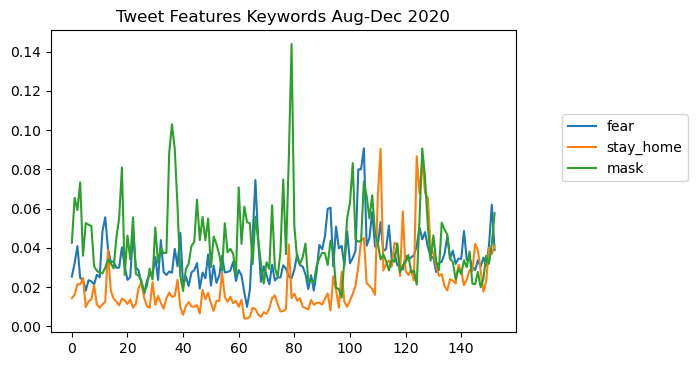

In [6]:
plt.figure(dpi=100)
plt.plot(df_data['fear_rate'],label='fear')
plt.plot(df_data['stay_rate'],label='stay_home')
plt.plot(df_data['mask_rate'],label = 'mask')
#plt.plot(df_data['pos_rate'],label = 'pos')
#plt.plot(df_data['neg_rate'],label = 'neg')
plt.legend(loc=[1.1,0.5])
plt.title('Tweet Features Keywords Aug-Dec 2020')
plt.show()

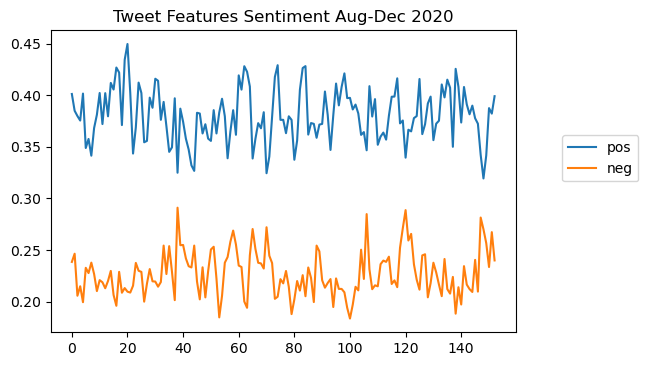

In [7]:
plt.figure(dpi=100)
plt.plot(df_data['pos_rate'],label = 'pos')
plt.plot(df_data['neg_rate'],label = 'neg')
plt.legend(loc=[1.1,0.5])
plt.title('Tweet Features Sentiment Aug-Dec 2020')
plt.show()

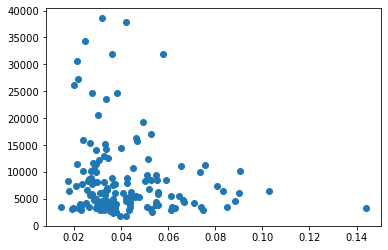

In [8]:
plt.scatter(df_data['mask_rate'],df_data['confirmed'])
plt.show()

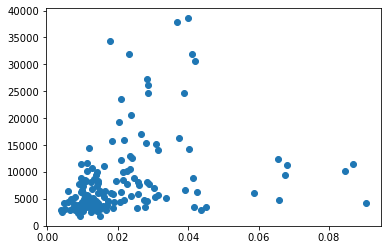

In [9]:
plt.scatter(df_data['stay_rate'],df_data['confirmed'])
plt.show()

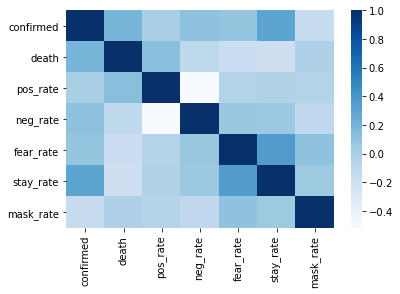

In [11]:
corr = df_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='Blues')
plt.show()

In [12]:
corr

,confirmed,death,pos_rate,neg_rate,fear_rate,stay_rate,mask_rate
confirmed,1.000000,0.196699,-0.000470,0.114685,0.081658,0.303944,-0.153447
death,0.196699,1.000000,0.128388,-0.102386,-0.178711,-0.191191,-0.029683
pos_rate,-0.000470,0.128388,1.000000,-0.518837,-0.047030,-0.038544,-0.051708
neg_rate,0.114685,-0.102386,-0.518837,1.000000,0.070871,0.058455,-0.107141
fear_rate,0.081658,-0.178711,-0.047030,0.070871,1.000000,0.362099,0.109367
stay_rate,0.303944,-0.191191,-0.038544,0.058455,0.362099,1.000000,0.053920
mask_rate,-0.153447,-0.029683,-0.051708,-0.107141,0.109367,0.053920,1.000000
